In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from numpy import log
import statsmodels.api as sm

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
os.chdir('C:\\Users\\emile.s\\Desktop\\Python Programming\\Work')

## Import data

In [6]:
dateparse = lambda dates: datetime.strptime(dates, '%Y/%m/%d')
data = pd.read_csv('YSoftDataExportFull_aggregated_school_month.csv', parse_dates=['DateMonth'], index_col='DateMonth',date_parser=dateparse)
print (data.head())

           CompanyCode   Pages  Devices  Learners
DateMonth                                        
2017-09-01         NaN   11738        2         0
2017-10-01         NaN  104851        6         0
2017-11-01         NaN  171714        6         0
2017-12-01         NaN   58537        7         0
2018-01-01         NaN  142226        7         0


<AxesSubplot:xlabel='DateMonth'>

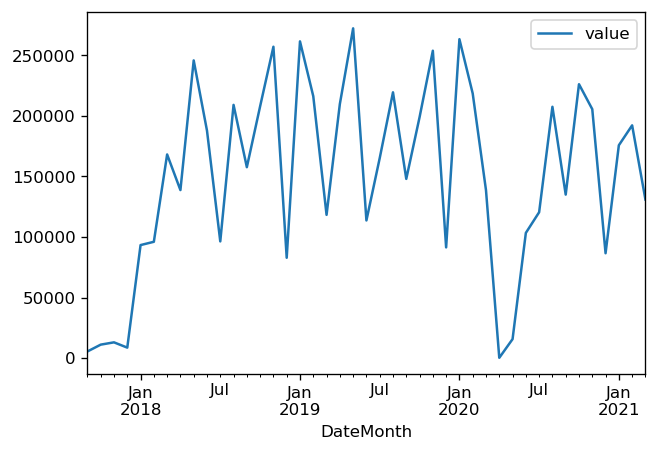

In [12]:
df = data.loc[:, ['CompanyCode', 'Pages']][data['CompanyCode'] == 'CDV']
df = df.resample('M').first().fillna(0)
df.columns = ['CompanyCode', 'value']
df.plot(figsize=(6,4))

## Test for stationarity (Augmented Dickey Fuller test)

In [8]:
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.973741
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


##### Is p-value larger than level of significance (0.05)? If so, differencing required.

## Test for seasonality & trend (Decomposition)

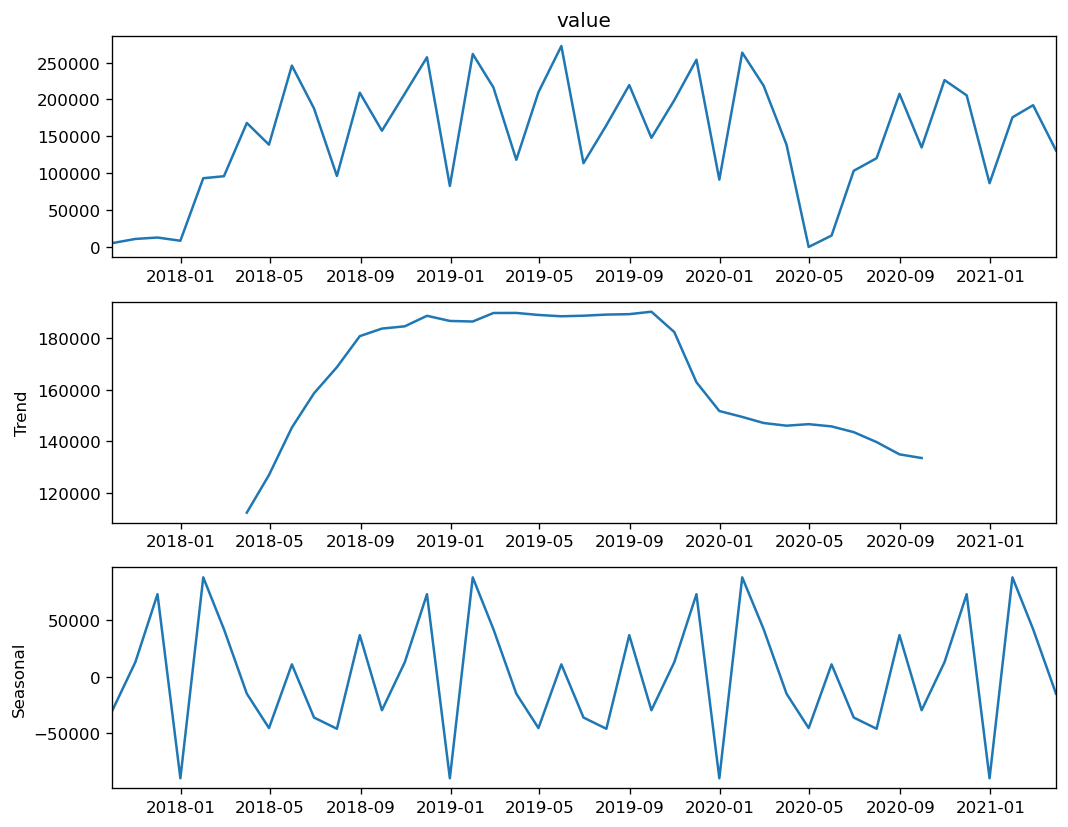

In [13]:
decomposition = sm.tsa.seasonal_decompose(df.value, model='additive')
fig = decomposition.plot(resid=False)
plt.show()

## Difference the time series (if required)

C:\Users\emile.s\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\emile.s\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


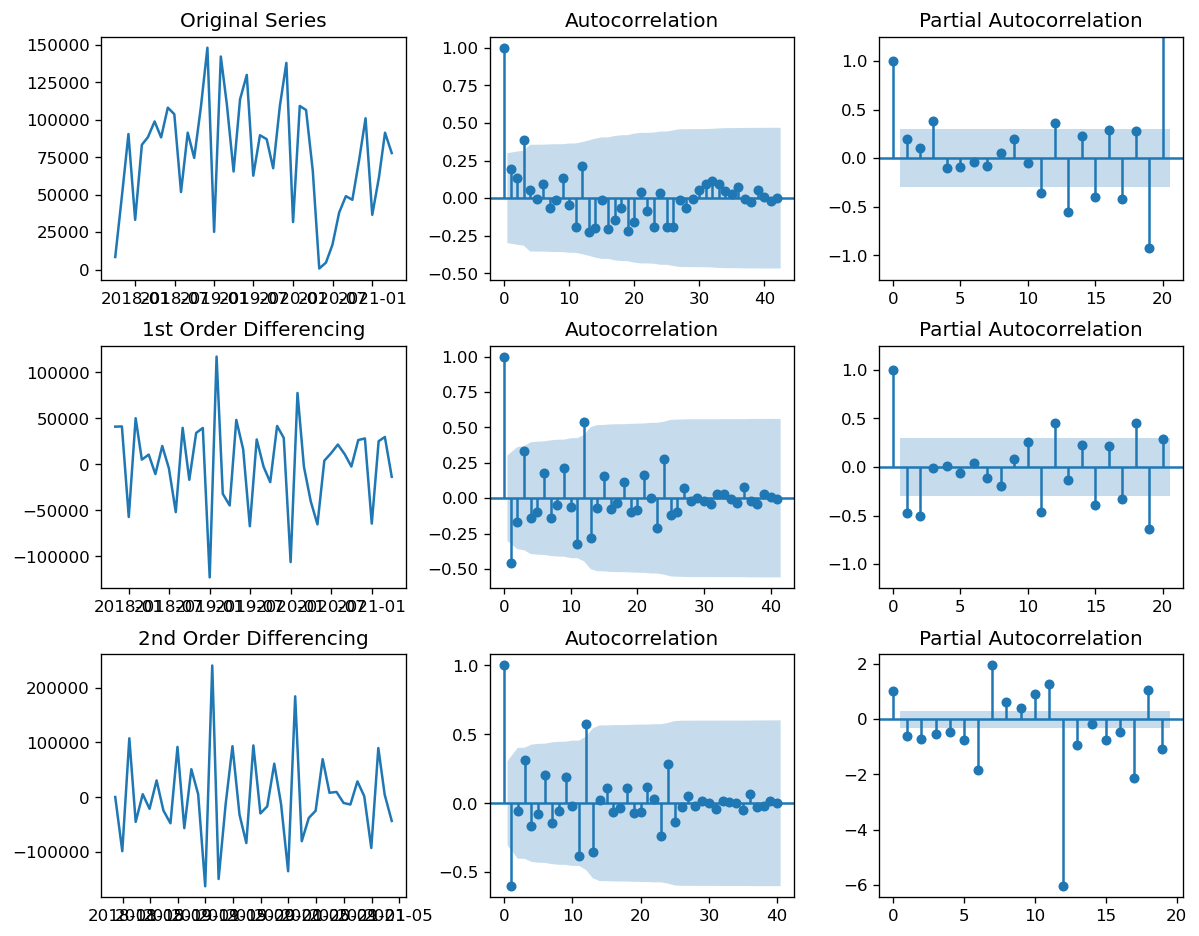

In [107]:
# Original Series
fig, axes = plt.subplots(3, 3, figsize=(10,8))
fig.tight_layout(pad=2.0)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], lags=len(df.value)-1)
axes[0,2].set(ylim=(-1.25, 1.25))
plot_pacf(df.value, ax=axes[0, 2], lags=len(df.value)/2-1)

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1], lags=len(df.value.diff().dropna())-1)
axes[1,2].set(ylim=(-1.25, 1.25))
plot_pacf(df.value.diff().dropna(), ax=axes[1, 2], lags=len(df.value.diff().dropna())/2-1)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], lags=len(df.value.diff().diff().dropna())-1)
plot_pacf(df.value.diff().diff().dropna(), ax=axes[2, 2], lags=len(df.value.diff().diff().dropna())/2-1)

plt.show()

### Test for stationarity after differencing

In [ ]:
result = adfuller(df.value.diff().dropna()) # d = 1
print('Number of differencing transformations: 1')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [86]:
from pmdarima.arima.utils import ndiffs
y = df.value

## Adf Test
print(ndiffs(y, test='adf'))

# KPSS test
print(ndiffs(y, test='kpss'))

# PP test:
print(ndiffs(y, test='pp'))

1
0
0


## Auto ARIMA model (if non-seasonal)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=653.798, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=634.770, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=651.949, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=613.512, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=605.277, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=606.129, Time=0.13 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=603.492, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=611.516, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=605.319, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=604.495, Time=0.07 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.495 seconds


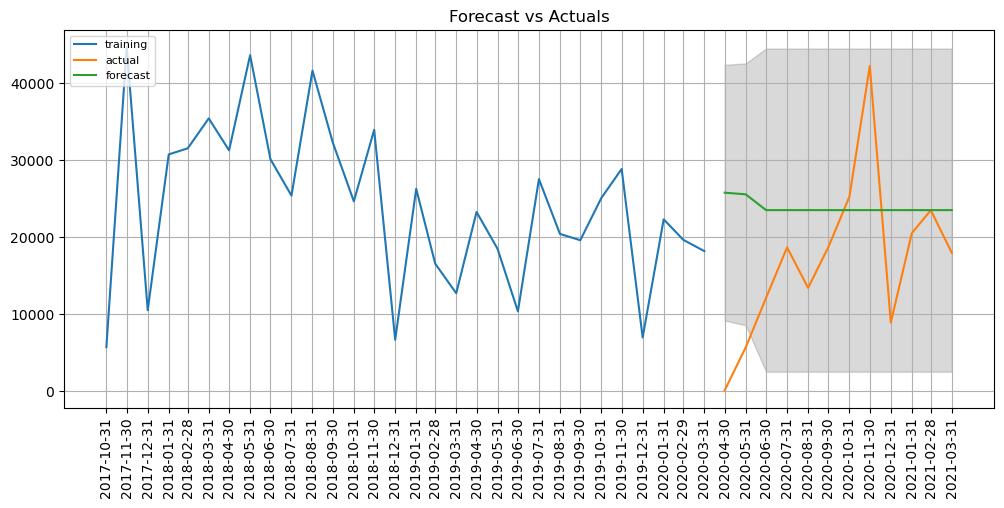

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -314.255
Date:                Fri, 26 Mar 2021   AIC                            636.510
Time:                        08:06:00   BIC                            642.114
Sample:                             0   HQIC                           638.303
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.354e+04   2179.059     10.805      0.000    1.93e+04    2.78e+04
ma.L1         -0.2223      0.152     -1.466      0.143      -0.519       0.075
ma.L2          0.7408      0.229      3.236      0.0

In [115]:
#from statsmodels.tsa.arima_model import ARIMA
n_periods = 12

# Create Training and Test
train = df.value[:len(df.value)-n_periods]
test = df.value[len(df.value)-n_periods:]

model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,              # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

fitted, confint = smodel.predict(n_periods = n_periods, return_conf_int=True, index=test.index)

fitted_series = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fitted_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks=df.index, rotation=90)
plt.grid(True)
plt.show()
print(smodel.summary())

## Auto SARIMA model (if seasonal)

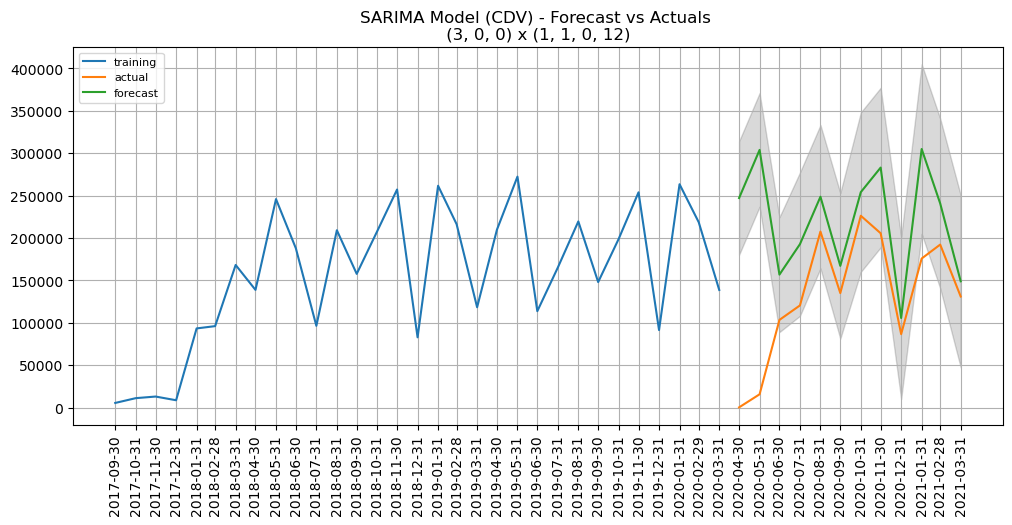

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   31
Model:             SARIMAX(3, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -229.661
Date:                            Tue, 30 Mar 2021   AIC                            469.322
Time:                                    09:20:28   BIC                            474.044
Sample:                                         0   HQIC                           470.121
                                             - 31                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0081      0.116     -0.070      0.944      -0.236       0.219
ar.L2          0.1489      0.108   

In [24]:
# Create Training and Test
train = df.value[:len(df.value)-12]
test = df.value[len(df.value)-12:]

# Build Model
### Important to test different differencing levels, especially on the seasonal component
smodel = pm.auto_arima(train,
                       start_p=0, d=0,     start_q=0,
                       max_p=5,   max_d=2, max_q=5, 
                       start_P=0, D=1,     start_Q=0, 
                       max_P=5,   max_D=1, max_Q=5, 
                       m=12, stationary=False, seasonal=True,
                       error_action='warn', trace=False, supress_warnings=True, stepwise=True,
                       random_state=20, n_fits=108, test='adf')

params = [smodel.get_params()['order'], smodel.get_params()['seasonal_order']]
school = df.CompanyCode.unique()[0]

fitted, confint = smodel.predict(n_periods = 12, return_conf_int=True)

prediction = pd.DataFrame(fitted,index=test.index)
prediction.columns = ['value']
lower_series = pd.Series(confint[:, 0], test.index)
upper_series = pd.Series(confint[:, 1], test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(prediction, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('SARIMA Model ({}) - Forecast vs Actuals \n {} x {} '.format(school, params[0], params[1]))
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks=df.index, rotation=90)
plt.grid(True)
plt.show()
print(smodel.summary())

## Validate the model

#### Plot residuals to identify trends or seasonality in forecast

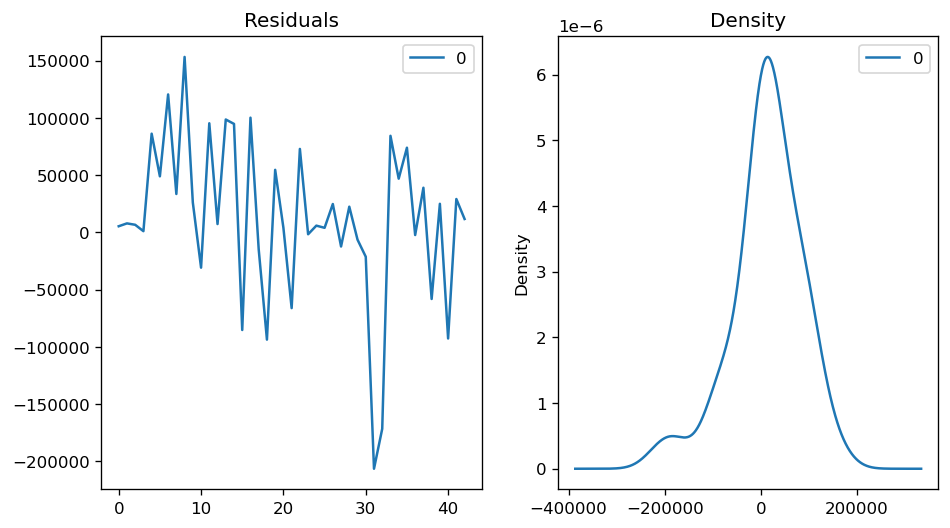

In [34]:
# Plot residual errors
residuals = pd.DataFrame(smodel.resid())
fig, ax = plt.subplots(1,2, figsize=(9,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### Other accuracy metrics

In [132]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]              # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\Users\emile.s\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\emile.s\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.4667461868558851,
 'me': -9760.190773231805,
 'mae': 22242.36392691118,
 'mpe': 0.0898354308140954,
 'rmse': 27441.298413730226,
 'acf1': 0.2216813041762504,
 'corr': -0.6800247568199279,
 'minmax': 0.31325586862322796}